In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f

df = pd.read_csv('../../datasets/students_simple.csv')

print("Первые 5 строк данных:")
print(df.head())
print(df.shape)

Первые 5 строк данных:
   height  mass  income   iq  pages  age    bmi  work_exp  friends  test_time
0     159    45     430   95     24   20  3.533        26        5        8.5
1     160    61     640  115     32   25  2.623        63        7        6.2
2     161    56     610  111     24   28  2.875        94       10        6.8
3     162    48     330   97     24   19  3.375        16        4       12.0
4     162    54     420  105     60   23  3.000        49        2        7.5
(20, 10)


In [38]:
N = 16

col_index_1 = N % 5
col_index_2 = (N**2) % 5 + 5

X = df.iloc[:, col_index_1].values
Y = df.iloc[:, col_index_2].values
n = len(X)

print(f"Столбец X (индекс {col_index_1}): {df.columns[col_index_1]}")
print(f"Столбец Y (индекс {col_index_2}): {df.columns[col_index_2]}")

Столбец X (индекс 1): mass
Столбец Y (индекс 6): bmi


In [40]:
mean_X = np.mean(X)
mean_Y = np.mean(Y)
sign_X = np.sign(X - mean_X)
sign_Y = np.sign(Y - mean_Y)
product_of_signs = sign_X * sign_Y
K_Fechner = np.sum(product_of_signs) / n
print(f"Коэффициент Фехнера : {K_Fechner:.4f}")

Коэффициент Фехнера : -0.9000


In [42]:
dev_X = X - mean_X
dev_Y = Y - mean_Y
numerator = np.sum(dev_X * dev_Y) # ковариация
denominator = np.sqrt(np.sum(dev_X**2) * np.sum(dev_Y**2)) # нормализующий член 
r_Pearson = numerator / denominator
print(f"Коэффициент Пирсона : {r_Pearson:.4f}")
Z = 0.5 * np.log((1 + r_Pearson) / (1 - r_Pearson)) # преобразование Фишера для перехода к примерно нормальному распределению
SE_Z = 1 / np.sqrt(n - 3) # Вычисляется стандартная ошибка для преобразованной величины Z. 
# показывает стандартное отклонение выборочного распределения Z
z_crit = 1.95 # соответствует Z-оценке, которая отсекает по 2.5% с каждого края нормального распределения
Z_lower = Z - z_crit * SE_Z
Z_upper = Z + z_crit * SE_Z
r_lower = (np.exp(2 * Z_lower) - 1) / (np.exp(2 * Z_lower) + 1)
r_upper = (np.exp(2 * Z_upper) - 1) / (np.exp(2 * Z_upper) + 1) # обратное преобразование Фишера

print(f"95% Доверительный интервал Пирсона: [{r_lower:.4f}, {r_upper:.4f}]")

Коэффициент Пирсона : -0.9606
95% Доверительный интервал Пирсона: [-0.9845, -0.9016]


In [44]:
def get_ranks(arr):
    temp = arr.argsort() # [88, 55, 99, 77] => [1, 3, 0, 2] - меньшее число находиться на позиции 1, следующее на позиции 3 ...
    ranks = temp.argsort() + 1 # [2, 0, 3, 1] + 1 => [3, 1, 4, 2] - ранг
    
    df_rank = pd.Series(arr).rank(method='average') # [10, 20, 20, 30] 20 => не 2 а (2+3)/2 = 2.5 из-за повторения
    return df_rank.values

rank_X = get_ranks(X)
rank_Y = get_ranks(Y)

d = rank_X - rank_Y
d_squared_sum = np.sum(d**2)

rho_Spearman = 1 - (6 * d_squared_sum) / (n * (n**2 - 1))

print(f"Коэффициент Спирмена : {rho_Spearman:.4f}")

Коэффициент Спирмена : -0.9827


In [46]:
concordant_pairs = 0
discordant_pairs = 0 # счетчики 
n_pairs = n * (n - 1) / 2

for i in range(n):
    for j in range(i + 1, n): # перебрать каждую уникальную пару наблюдений ровно один раз
        diff_X = X[i] - X[j]
        diff_Y = Y[i] - Y[j]
        if diff_X * diff_Y > 0:
            concordant_pairs += 1
        elif diff_X * diff_Y < 0:
            discordant_pairs += 1

tau_Kendall = (concordant_pairs - discordant_pairs) / n_pairs

print(f"Коэффициент Кенделла : {tau_Kendall:.4f}")

Коэффициент Кенделла : -0.9316


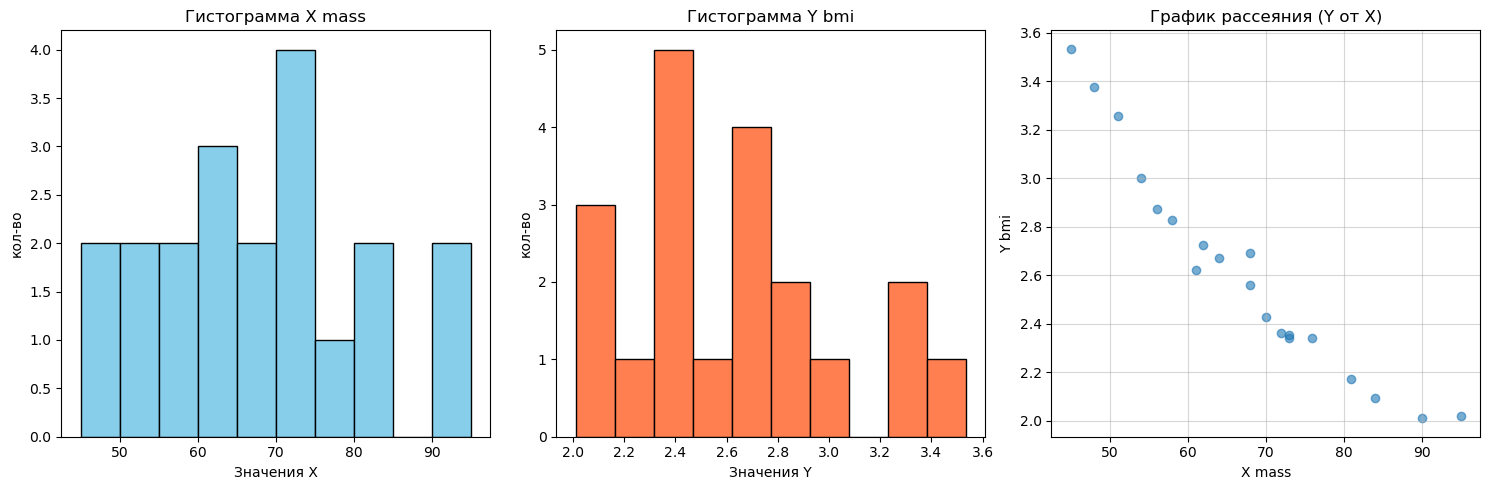

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(X, bins=None, color='skyblue', edgecolor='black')
plt.title('Гистограмма X mass')
plt.xlabel('Значения X')
plt.ylabel('кол-во')

plt.subplot(1, 3, 2)
plt.hist(Y, bins=None, color='coral', edgecolor='black')
plt.title('Гистограмма Y bmi')
plt.xlabel('Значения Y')
plt.ylabel('кол-во')


plt.subplot(1, 3, 3)
plt.scatter(X, Y, alpha=0.6, label='Исходные данные')
plt.title('График рассеяния (Y от X)')
plt.xlabel('X mass')
plt.ylabel('Y bmi')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [49]:
SST = np.sum((Y - mean_Y)**2) # Total Sum of Squares
results = {}

def ols_solve(X_matrix, Y_vector): # w=(XT X)^(−1) XT Y
    XT = X_matrix.T
    XTX = XT @ X_matrix
    XTX_inv = np.linalg.inv(XTX)
    XT_Y = XT @ Y_vector
    w = XTX_inv @ XT_Y
    return w

# Линейная регрессия
X_linear = np.vstack([np.ones(n), X]).T # "склеивает" столбец единиц и столбец данных X в одну матрицу
w_linear = ols_solve(X_linear, Y)
y_pred_linear = X_linear @ w_linear
SSE_linear = np.sum((Y - y_pred_linear)**2) # Sum of Squared Errors - часть разброса которую модель не смогла объяснить
R2_linear = 1 - SSE_linear / SST
results['linear'] = {'w': w_linear, 'R2': R2_linear, 'SSE': SSE_linear}
print(f"Линейная: y = {w_linear[1]:.4f}*x + {w_linear[0]:.4f}")
print(f"R2: {R2_linear:.4f}")

# Квадратичная регрессия
X_quadratic = np.vstack([np.ones(n), X, X**2]).T
w_quadratic = ols_solve(X_quadratic, Y)
y_pred_quadratic = X_quadratic @ w_quadratic
SSE_quadratic = np.sum((Y - y_pred_quadratic)**2)
R2_quadratic = 1 - SSE_quadratic / SST
results['quadratic'] = {'w': w_quadratic, 'R2': R2_quadratic, 'SSE': SSE_quadratic}
print(f"Квадратичная: y = {w_quadratic[2]:.4f}*x^2 + {w_quadratic[1]:.4f}*x + {w_quadratic[0]:.4f}")
print(f"R2: {R2_quadratic:.4f}")

# Гиперболическая регрессия
X_inv = 1 / X
X_hyperbolic = np.vstack([np.ones(n), X_inv]).T
w_hyperbolic = ols_solve(X_hyperbolic, Y) # линейную зависимость между Y и 1/X
y_pred_hyperbolic = X_hyperbolic @ w_hyperbolic
SSE_hyperbolic = np.sum((Y - y_pred_hyperbolic)**2)
R2_hyperbolic = 1 - SSE_hyperbolic / SST
results['hyperbolic'] = {'w': w_hyperbolic, 'R2': R2_hyperbolic, 'SSE': SSE_hyperbolic}
print(f"Гиперболическая: y = {w_hyperbolic[1]:.4f}/x + {w_hyperbolic[0]:.4f}")
print(f"R2: {R2_hyperbolic:.4f}")

# Показательная регрессия
    # ln(y) = ln(w0 * w1^x)
    # ln(y) = ln(w0) + ln(w1^x)
    # ln(y) = ln(w0) + x * ln(w1)
Y_ln = np.log(Y)
X_exp = np.vstack([np.ones(n), X]).T
w_ln = ols_solve(X_exp, Y_ln)

w0_exp = np.exp(w_ln[0])
w1_exp = np.exp(w_ln[1])
w_exponential = np.array([w0_exp, w1_exp])

y_pred_exponential = w0_exp * (w1_exp ** X)
SSE_exponential = np.sum((Y - y_pred_exponential)**2)
R2_exponential = 1 - SSE_exponential / SST
results['exponential'] = {'w': w_exponential, 'R2': R2_exponential, 'SSE': SSE_exponential}
print(f"Показательная: y = {w_exponential[0]:.4f} * {w_exponential[1]:.4f}^x")
print(f"R2: {R2_exponential:.4f}")

Линейная: y = -0.0308*x + 4.6881
R2: 0.9228
Квадратичная: y = 0.0005*x^2 + -0.0990*x + 6.9596
R2: 0.9779
Гиперболическая: y = 135.2427/x + 0.5275
R2: 0.9791
Показательная: y = 5.6857 * 0.9884^x
R2: 0.9542


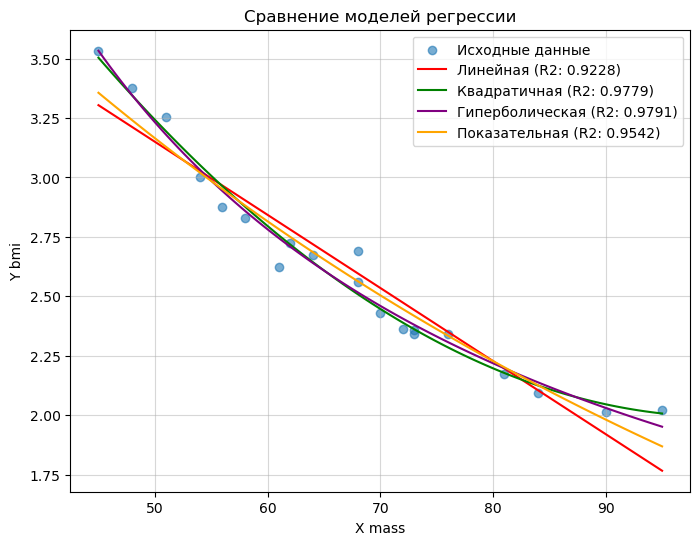

In [52]:
X_plot = np.linspace(X.min(), X.max(), 100) # генерирует 100 равномерно распределенных точек в диапазоне

y_plot_linear = results['linear']['w'][1] * X_plot + results['linear']['w'][0]

w_q = results['quadratic']['w']
y_plot_quadratic = w_q[2] * X_plot**2 + w_q[1] * X_plot + w_q[0]

y_plot_hyperbolic = results['hyperbolic']['w'][1] / X_plot + results['hyperbolic']['w'][0]

w_e = results['exponential']['w']
y_plot_exponential = w_e[0] * (w_e[1] ** X_plot)

plt.figure(figsize=(8, 6))
plt.scatter(X, Y, alpha=0.6, label='Исходные данные')
plt.plot(X_plot, y_plot_linear, color='red', label=f'Линейная (R2: {R2_linear:.4f})')
plt.plot(X_plot, y_plot_quadratic, color='green', label=f'Квадратичная (R2: {R2_quadratic:.4f})')
plt.plot(X_plot, y_plot_hyperbolic, color='purple', label=f'Гиперболическая (R2: {R2_hyperbolic:.4f})')
plt.plot(X_plot, y_plot_exponential, color='orange', label=f'Показательная (R2: {R2_exponential:.4f})')

plt.title('Сравнение моделей регрессии')
plt.xlabel('X mass')
plt.ylabel('Y bmi')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

In [53]:
r2_values = {model_name: data['R2'] for model_name, data in results.items()}
print("R-квадрат :", r2_values)

best_model_name = max(r2_values, key=r2_values.get)
worst_model_name = min(r2_values, key=r2_values.get)

print(f"\nЛучшая модель: '{best_model_name}' (R²={r2_values[best_model_name]:.4f})")
print(f"Худшая модель: '{worst_model_name}' (R²={r2_values[worst_model_name]:.4f})")

print(f"\n--- Критерий Фишера для НАИЛУЧШЕЙ модели ({best_model_name}) ---")
SSE_best = results[best_model_name]['SSE']
SSR_best = SST - SSE_best

if best_model_name == 'quadratic':
    p_best = 2
else:
    p_best = 1

df_reg_best = p_best # степень свободы регрессии
df_res_best = n - p_best - 1 # степень свободы остатка
MSR_best = SSR_best / df_reg_best # средний квадрат регрессии - "средняя объясненная вариация" на один предиктор
MSE_best = SSE_best / df_res_best # средний квадрат ошибки - "средняя необъясненная вариация" на один предиктор
F_stat_best = MSR_best / MSE_best
F_crit_best = f.ppf(0.95, df_reg_best, df_res_best) # критическое значение Фишера

print(f"F-статистика: {F_stat_best:.4f}")
print(f"Критическое F: {F_crit_best:.4f}")
print("Результат:", "Модель значима" if F_stat_best > F_crit_best else "Модель не значима")

# --- Проверка НАИХУДШЕЙ модели ---
print(f"\n--- Критерий Фишера для НАИХУДШЕЙ модели ({worst_model_name}) ---")
SSE_worst = results[worst_model_name]['SSE']
SSR_worst = SST - SSE_worst

if worst_model_name == 'quadratic':
    p_worst = 2
else:
    p_worst = 1

df_reg_worst = p_worst
df_res_worst = n - p_worst - 1
MSR_worst = SSR_worst / df_reg_worst
MSE_worst = SSE_worst / df_res_worst
F_stat_worst = MSR_worst / MSE_worst
F_crit_worst = f.ppf(0.95, df_reg_worst, df_res_worst)

print(f"F-статистика: {F_stat_worst:.4f}")
print(f"Критическое F: {F_crit_worst:.4f}")
print("Результат:", "Модель значима" if F_stat_worst > F_crit_worst else "Модель не значима")

R-квадрат : {'linear': 0.9227705659015859, 'quadratic': 0.9779302384431465, 'hyperbolic': 0.979132744595704, 'exponential': 0.9542387362820841}

Лучшая модель: 'hyperbolic' (R²=0.9791)
Худшая модель: 'linear' (R²=0.9228)

--- Критерий Фишера для НАИЛУЧШЕЙ модели (hyperbolic) ---
F-статистика: 844.5955
Критическое F: 4.4139
Результат: Модель значима

--- Критерий Фишера для НАИХУДШЕЙ модели (linear) ---
F-статистика: 215.0718
Критическое F: 4.4139
Результат: Модель значима
